In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
import keras
get_ipython().run_line_magic('matplotlib', 'inline')
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize
import seaborn as sns
import cv2

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [5]:
trainData = unpickle(r'C:\Users\Utsav\OneDrive\Desktop\projects\CIPHAR-100\Dataset\train')
testData = unpickle(r'C:\Users\Utsav\OneDrive\Desktop\projects\CIPHAR-100\Dataset\test')
metaData = unpickle(r'C:\Users\Utsav\OneDrive\Desktop\projects\CIPHAR-100\Dataset\meta')

In [6]:
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [7]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


In [8]:
print(np.unique(trainData['fine_labels']))
print(np.unique(trainData['coarse_labels']))
print(trainData['batch_label'])
print(len(trainData['filenames']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
training batch 1 of 1
50000


In [9]:
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
category

,SuperClass
0,aquatic_mammals
1,fish
2,flowers
3,food_containers
4,fruit_and_vegetables
5,household_electrical_devices
6,household_furniture
7,insects
8,large_carnivores
9,large_man-made_outdoor_things


In [10]:
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])
subCategory

,SubClass
0,apple
1,aquarium_fish
2,baby
3,bear
4,beaver
...,...
95,whale
96,willow_tree
97,wolf
98,woman


In [11]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [12]:
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)

Image number selected : 17014
Shape of image : (32, 32, 3)
Image category number: 13
Image category name: Non-insect_invertebrates
Image subcategory number: 77
Image subcategory name: Snail


C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_16824\4293325046.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_16824\4293325046.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))


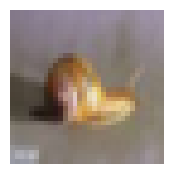

In [13]:
rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Shape of image : {}".format(X_train[imageId].shape))
print("Image category number: {}".format(trainData['coarse_labels'][imageId]))
print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))
print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))

C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_16824\3075283629.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())


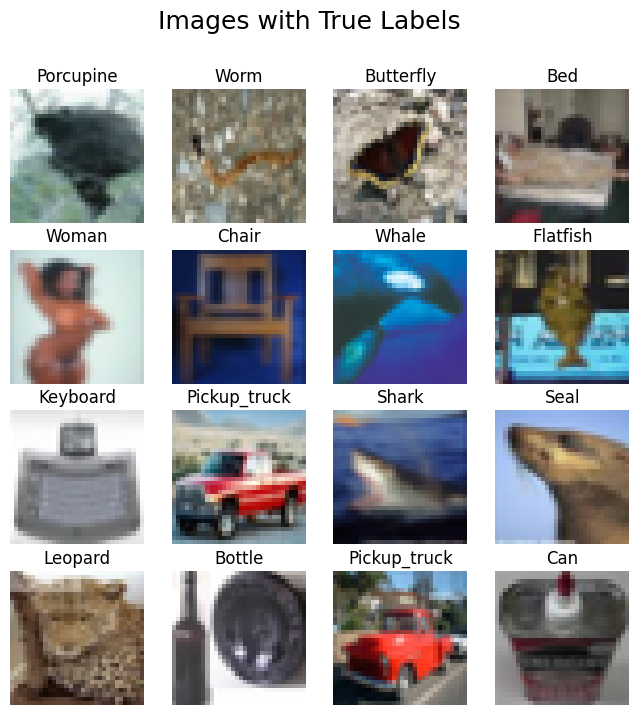

In [14]:
rcParams['figure.figsize'] = 8,8

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_train), num_row * num_col)
#imageId

fig, axes = plt.subplots(num_row, num_col)
plt.suptitle('Images with True Labels', fontsize=18)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_train[imageId[k]])
        axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())
        axes[i,j].axis('off')

In [15]:
#transforming the testing dataset
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
X_test.shape

(10000, 32, 32, 3)

In [16]:
y_train = trainData['fine_labels']
#y_train

y_test = testData['fine_labels']
#y_test

In [17]:
num_class = 100

y_train = keras.utils.to_categorical(y_train, num_class)
#y_train

y_test = keras.utils.to_categorical(y_test, num_class)
#y_test

In [18]:
X_train = X_train / 255.
#X_train

X_test = X_test / 255.
#X_test

In [34]:
# initializing CNN model
model = Sequential()

#Stack 1
#convolution
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.2))

#Stack 2
#convolution
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=2, strides=1))
model.add(Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"))
#pooling

#dropout
model.add(Dropout(0.5))

#Stack 3
#convolution
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.3))

#Stack 4
#convolution
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, padding="same", activation="relu"))
#pooling
model.add(MaxPool2D(pool_size=2, strides=2))
#dropout
model.add(Dropout(0.3))

#flattening
model.add(Flatten())

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout
model.add(Dropout(0.3))

#full connection
model.add(Dense(units=1000, activation="relu"))
#dropout
model.add(Dropout(0.3))

#output layer
model.add(Dense(units=num_class, activation="softmax"))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                    

In [36]:
epochs = 100
batch_size = 64

In [37]:
optimizer = keras.optimizers.Adam(lr=0.0001)

#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#saving the model checkpoint for the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [39]:
#image augmentation to expand the training dataset
#validation split to test the model
data_gen = ImageDataGenerator(
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            featurewise_center=True,
            width_shift_range=0.1,
            validation_split=0.2)

data_gen.fit(X_train, seed=123)

train_data_gen = data_gen.flow(X_train, y_train,
                               batch_size=batch_size,
                               subset="training", seed=123)

valid_data_gen = data_gen.flow(X_train, y_train,
                               batch_size=batch_size,
                               subset="validation", seed=123)

In [40]:
model_history = model.fit(train_data_gen,
                          steps_per_epoch=40000//batch_size,
                          validation_data=valid_data_gen,
                          validation_steps=10000//batch_size,
                          callbacks=[early_stop, model_checkpoint],
                          verbose=1,
                          epochs=epochs)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 4.4467 - accuracy: 0.0188
Epoch 1: val_loss improved from inf to 4.30255, saving model to best_model.h5
625/625 [==============================] - 59s 86ms/step - loss: 4.4467 - accuracy: 0.0188 - val_loss: 4.3026 - val_accuracy: 0.0319
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 4.0907 - accuracy: 0.0571
Epoch 2: val_loss improved from 4.30255 to 3.85809, saving model to best_model.h5
625/625 [==============================] - 55s 88ms/step - loss: 4.0907 - accuracy: 0.0571 - val_loss: 3.8581 - val_accuracy: 0.0915
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 3.7238 - accuracy: 0.1140
Epoch 3: val_loss improved from 3.85809 to 3.57286, saving model to best_model.h5
625/625 [==============================] - 55s 88ms/step - loss: 3.7238 - accuracy: 0.1140 - val_loss: 3.5729 - val_accuracy: 0.1412
Epoch 4/100
625/625 [==============================] - ETA: 0s - los

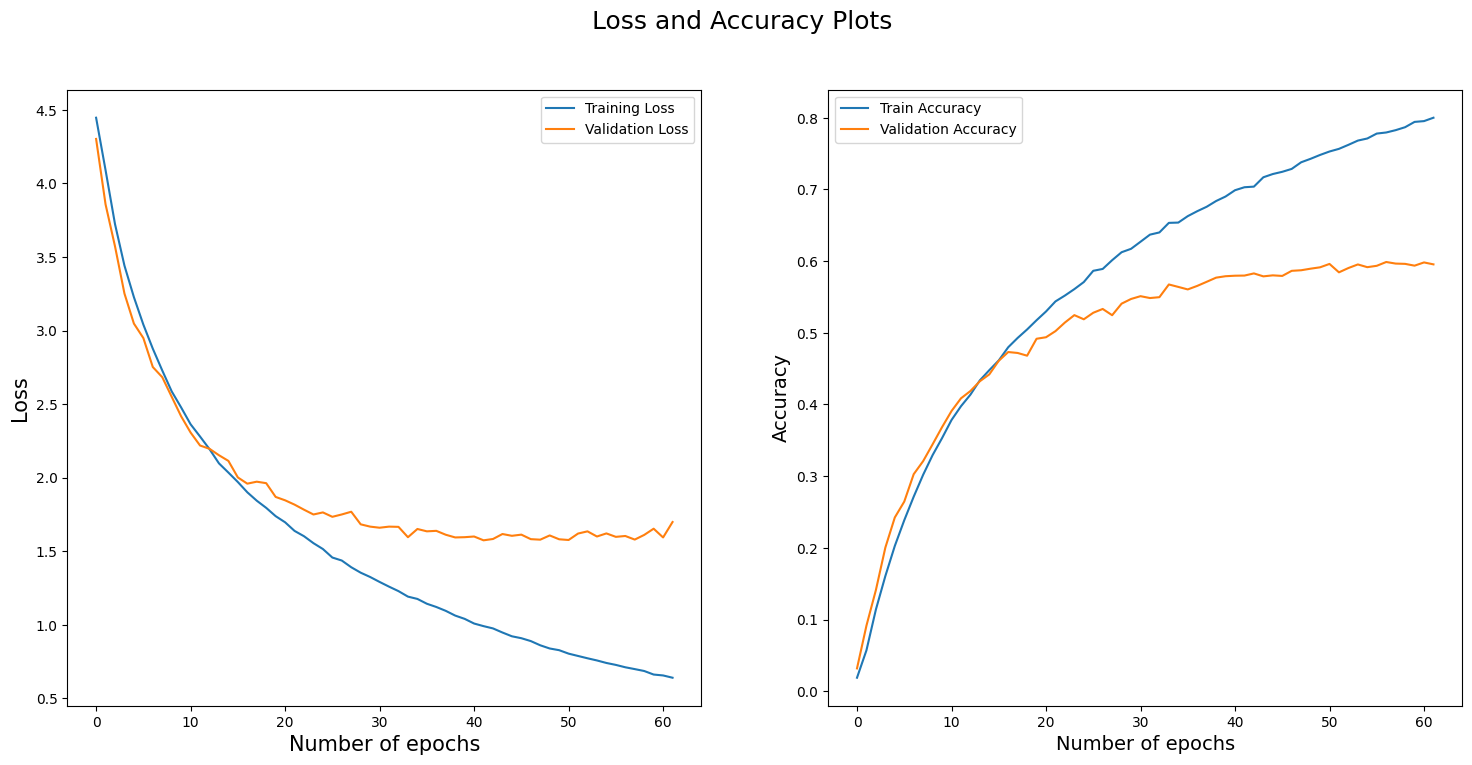

In [41]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [42]:
#train_loss, train_accuracy = model.evaluate_generator(generator=train_data_gen, steps=40000//batch_size)
valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_gen, steps=10000//batch_size)
test_loss, test_accuracy = model.evaluate_generator(data_gen.flow(X_test, y_test, seed=123), steps=len(X_test)//batch_size)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")
print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")
print(" ")
print('Validation Loss: ', round(valid_loss, 2))
print('Test Loss: ', round(test_loss, 2))

C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_16824\2992606394.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(generator=valid_data_gen, steps=10000//batch_size)
C:\Users\Dwaipayan Nandi\AppData\Local\Temp\ipykernel_16824\2992606394.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(data_gen.flow(X_test, y_test, seed=123), steps=len(X_test)//batch_size)


Validation Accuracy:  59.49 %
Test Accuracy:  59.38 %
 
Validation Loss:  1.71
Test Loss:  1.72
